# Tecnicas no parametricas

### Ejercicio 1 

In [6]:
import numpy as np
from scipy.ndimage.interpolation import shift
import matplotlib.pyplot as plt

# Defino los estimadores de la correlacion
def estimadorAutocorrInsesgado(y):  
    N = y.size
    R = np.zeros(N)

    for k in range(N):
        yshift = shift(y, k, cval = 0)
        R[k] = np.dot(y, yshift) / (N - k)

    return R

def estimadorAutocorrSesgado(y):  
    N = y.size
    R = np.zeros(N)

    for k in range(N):
        yshift = shift(y, k, cval = 0)
        R[k] = np.dot(y, yshift) / N

    return R

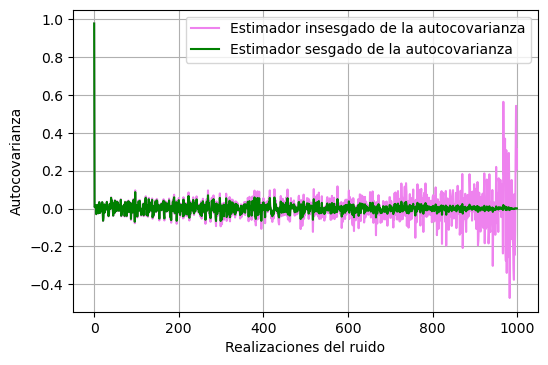

In [16]:
## CAMBIAR A 10000 MUESTRAS! ##
m = 1000 # Cantidad de realizaciones 

muRuido = 0
sigmaRuido = 1

# Muestras de ruido blanco
# Cw = Rw 
# Estimar la covarianza es estimar su correlacion
W = np.random.normal(muRuido, sigmaRuido, m)

# covarianza teorica es una delta d(k)
k = np.arange(0,m,1)

rwws = estimadorAutocorrSesgado(W)
rwwi = estimadorAutocorrInsesgado(W)

plt.figure(dpi=100)

plt.plot(k,rwwi, label = 'Estimador insesgado de la autocovarianza', color = 'violet')
plt.plot(k,rwws, label = 'Estimador sesgado de la autocovarianza' , color = 'green')
plt.legend(loc = 'best')
plt.ylabel('Autocovarianza')
plt.xlabel('Realizaciones del ruido')
plt.savefig('acorr.png')
plt.grid(True)
plt.show()

### Ejercicio 2 Periodogramas
Para el sistema H(z)  se grafica la psd, el periodograma y el estimador Blackman Tukey

#### 1) Verdadera psd de Y:

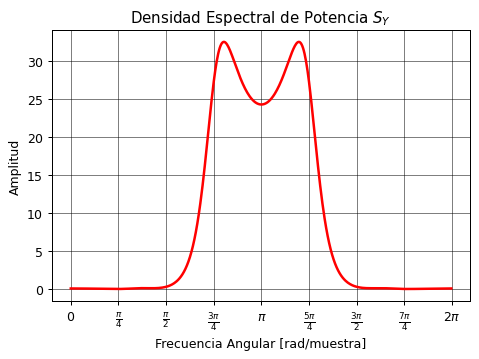

In [14]:
from scipy import signal  

hDenominador = np.array([1, 0.3544, 0.3508, 0.1736, 0.2401])
hNumerador = np.array([1, -1.3817, 1.5632, -0.8843, 0.4096])
[eje_freq, Syy_teorico] = signal.freqz(hNumerador,  hDenominador, whole = True) # En frecuencias rad/sample * 2pi

plt.figure(dpi=90)
plt.plot(eje_freq, ((pow(np.abs(Syy_teorico), 2))), linewidth = 2, color = 'red')
plt.title(r'Densidad Espectral de Potencia $S_Y$')
plt.xlabel('Frecuencia Angular [rad/muestra]')
plt.ylabel('Amplitud')
plt.xticks([ 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 1.25*np.pi, 1.5*np.pi, 1.75*np.pi , 2* np.pi], 
           ['$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$', 
            r'$\frac{5\pi}{4}$', r'$\frac{3\pi}{2}$', r'$\frac{7\pi}{4}$',r'$2\pi$' ])

plt.grid(b = True, color = 'black', linestyle = '-', linewidth = 0.4)


#### 2)  Para 100 realizaciones el promedio del periodograma y su varianza

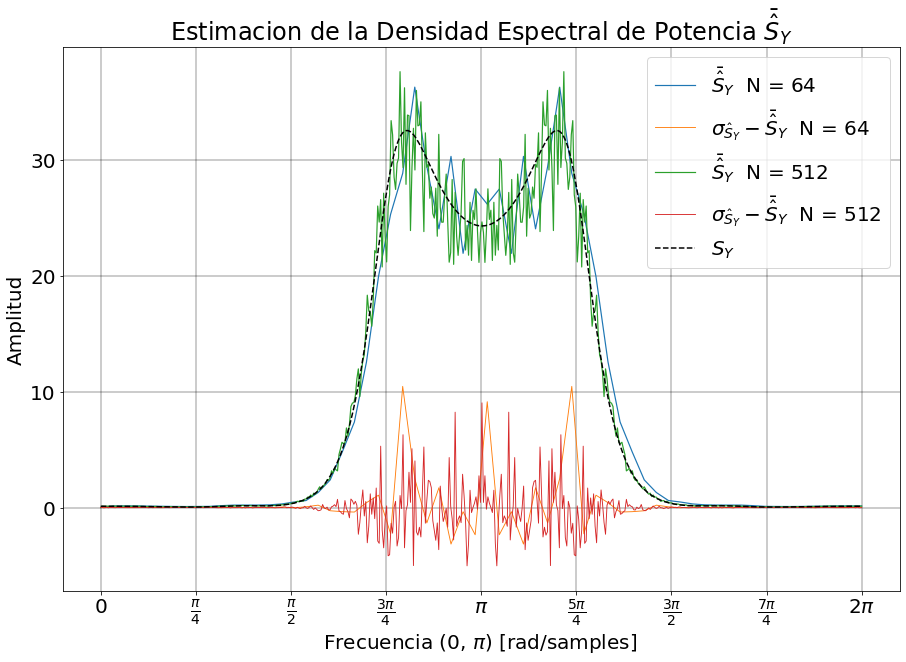

In [42]:
#X:Ruido de entrada
# Cantidad de realizaciones del proceso X
J = 100
# Cantidad de muestras de cada realizacion del proceso X
N = np.array([64,512]) # Para el ejercicio va esto!

plt.figure(figsize = (15,10))

for n in range(N.size):
    
    X = np.random.normal(0, 1, (J,N[n])) # Filas: Realizaciones ; Columnas: Muestras de una realizacion de un proceso
    w = np.linspace(0,2*np.pi,N[n]);

    # Filtro X con H(z)
    Y = signal.lfilter(hNumerador, hDenominador, X, axis = 1)

    # Media de las J's estiamaciones del periodograma de Sy
    Syy_promedio = np.zeros(int(N[n]))
    for i in range(J):
        # Periodograma de Y en frecuencia rad/sample normalizado ; Con nfft = n
        (wyy, syy) = signal.periodogram(Y[i], axis = -1, return_onesided = False, scaling = 'density', nfft = N[n]) 
        Syy_promedio += syy
    Syy_promedio /= J

    # Varianza : Iterar de vuelta y restar cada periodograma por la Syy_promedio
    SyySigma = np.zeros(int(N[n]))
    for i in range(J):
        (wyy, syy) = signal.periodogram(Y[i], return_onesided = False , scaling = 'density')
        SyySigma += pow((syy - Syy_promedio),2)
    SyySigma /= (J - 1)

    plt.plot(w, Syy_promedio, label = r'$\bar{\hat{S}}_Y$ ' + " N = {}".format(N[n]), linewidth=1.2)
    plt.plot(w, pow(SyySigma,1/2) - Syy_promedio, label = r'$\sigma_{\hat{S}_Y} - \bar{\hat{S}}_Y$ '+ " N = {}".format(N[n]),
             linewidth=0.9)
    
plt.plot(w, (pow(np.abs(Syy_teorico), 2)), label = r'$S_Y$', color = 'black', linestyle = '--') 

plt.title(r'Estimacion de la Densidad Espectral de Potencia $\bar{\hat{S}}_Y$')
plt.xlabel('Frecuencia (0, $\pi$) [rad/samples] ')
plt.ylabel('Amplitud')
plt.xticks([ 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 1.25*np.pi, 1.5*np.pi, 1.75*np.pi , 2* np.pi], 
           ['$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$', 
            r'$\frac{5\pi}{4}$', r'$\frac{3\pi}{2}$', r'$\frac{7\pi}{4}$',r'$2\pi$' ])
plt.grid(b = True, color = 'black', linestyle = '-', linewidth = 0.4)

plt.legend()


#### 3) Estimar la psd usando el estimador de Blackman Tukey

In [30]:
from scipy.signal import correlate
import numpy.fft as fft
# Vuelvo a definir el estimador sesgado de la correlacion, pero para valor de -k y k
def acorrSesgado(y):
    r = correlate(y, y) / len(y)
    l = np.arange(-(len(y)-1), len(y))
    return r,l

# Defino el estimador BT
def blackmanTukey(y, w, nfft):
    # w : ventana
    N = len(y)
    M = len(w)
    
    # Estimar la correlacion
    ryy, k = acorrSesgado(y)
    
    # Ventaneo la autocorrelacion
    ryy = ryy[np.logical_and(k >= -(M/2), k < M/2)]
    ryw = ryy * w
    
    # Computo la fft:
    Y = fft.fft(ryw, nfft)
    f = np.arange(nfft) / nfft # eje de frecuencias
    
    return (pow(np.abs(Y),1), f)

# Definiciones
nfft = 256
M2 = int(nfft/16)
M3 = int(nfft/4)
ventanaBox = signal.boxcar(nfft)
ventanaTri1 = np.bartlett(M2)
ventanaTri2 = np.bartlett(M3)

X = np.random.normal(0, 1, (J,256)) # Filas: Realizaciones ; Columnas: Muestras de una realizacion de un proceso
Y = signal.lfilter( hNumerador, hDenominador, X, axis = 1)

Para M = N y ventana rectangular:

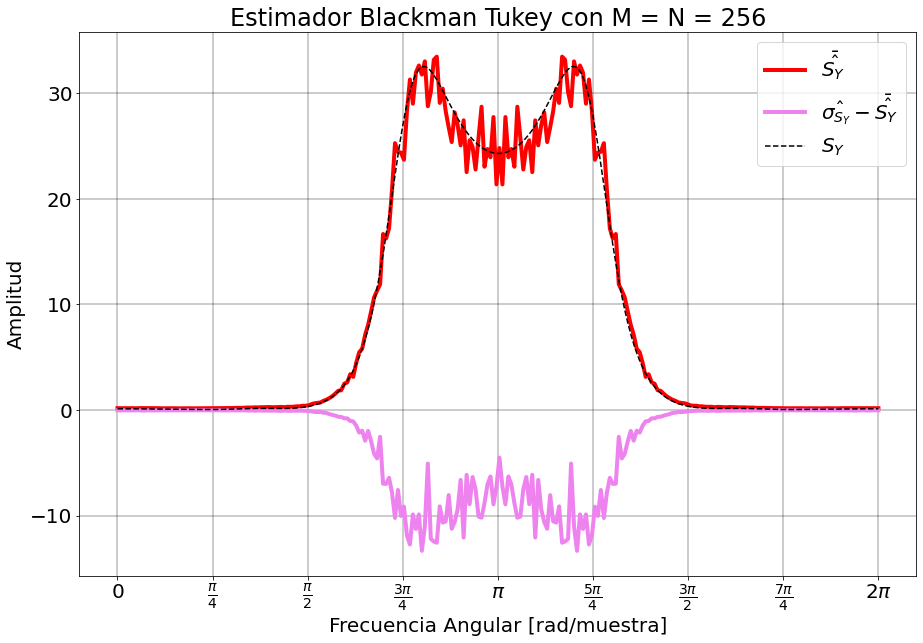

In [44]:
# Estimador con M = N y ventana rectangular
psd_mean = np.zeros(int(nfft))
for i in range(J):
    (psd, w) = blackmanTukey(Y[i], ventanaBox ,nfft)
    psd_mean += psd
psd_mean /= J

# Varianza : 
sigma_psd = np.zeros(int(nfft))
for i in range(J):
    (psd, w) = blackmanTukey(Y[i], ventanaBox ,nfft)
    sigma_psd += pow((psd - psd_mean),2)
sigma_psd /= (J - 1)


plt.figure(figsize = (15,10))
plt.plot(np.linspace(0,2*np.pi,nfft),psd_mean, linewidth = 4, color = 'red',label = r'$\bar{\hat{S_Y}}$')
plt.plot(np.linspace(0,2*np.pi,nfft),pow(sigma_psd,1/2) - psd_mean, linewidth = 4, color = 'violet',
         label = r'$\hat{\sigma_{S_Y}}-\bar{\hat{S_Y}}$')
plt.plot(np.linspace(0,2*np.pi,512),(pow(np.abs(Syy_teorico), 2)),linestyle = 'dashed' ,color = 'black',label = r'$S_Y$')

plt.title(r'Estimador Blackman Tukey con M = N = 256')
plt.xlabel('Frecuencia Angular [rad/muestra]')
plt.ylabel('Amplitud')
plt.grid(b = True, color = 'black', linestyle = '-', linewidth = 0.4)
plt.xticks([ 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 1.25*np.pi, 1.5*np.pi, 1.75*np.pi , 2* np.pi], 
           ['$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$', 
            r'$\frac{5\pi}{4}$', r'$\frac{3\pi}{2}$', r'$\frac{7\pi}{4}$',r'$2\pi$' ])
plt.rc('font', size=20)         
plt.legend()
plt.savefig("blackmanTukey256.png")


Para M = N/16 y ventana Bartlett

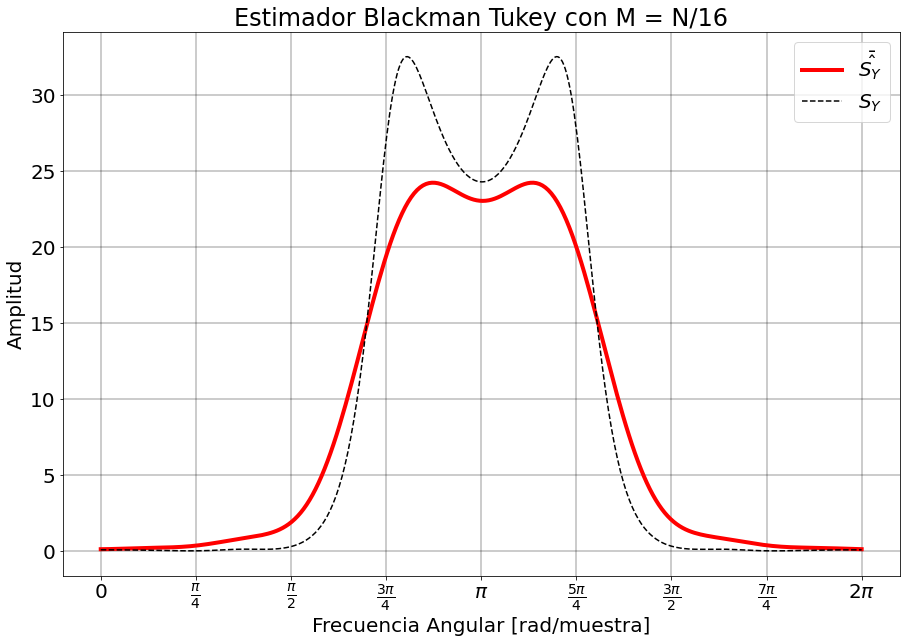

In [45]:
# Para M = N/16

psd_mean = np.zeros(int(nfft))
for i in range(J):
    (psd, w) = blackmanTukey(Y[i], ventanaTri1 ,nfft)
    psd_mean += psd
psd_mean /= J


plt.figure(figsize = (15,10))
plt.plot(np.linspace(0,2*np.pi,nfft),psd_mean, linewidth = 4, color = 'red',label = r'$\bar{\hat{S_Y}}$')
plt.plot(np.linspace(0,2*np.pi,512),(pow(np.abs(Syy_teorico), 2)),linestyle = 'dashed' ,color = 'black',label = r'$S_Y$')
plt.title(r'Estimador Blackman Tukey con M = N/16')
plt.xlabel('Frecuencia Angular [rad/muestra]')
plt.ylabel('Amplitud')
plt.grid(b = True, color = 'black', linestyle = '-', linewidth = 0.4)
plt.rc('font', size=20)     
plt.xticks([ 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 1.25*np.pi, 1.5*np.pi, 1.75*np.pi , 2* np.pi], 
           ['$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$', 
            r'$\frac{5\pi}{4}$', r'$\frac{3\pi}{2}$', r'$\frac{7\pi}{4}$',r'$2\pi$' ])
    
plt.legend()
plt.savefig("blackmanTukey16.png")


Con M = N/4

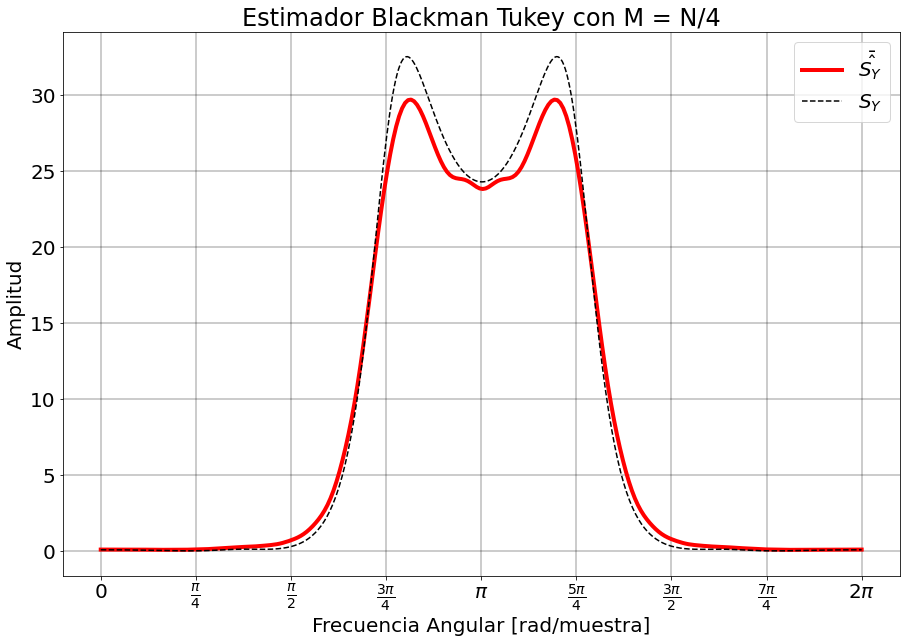

In [47]:

### Para M = N/4 ###

psd_mean = np.zeros(int(nfft))
for i in range(J):
    (psd, w) = blackmanTukey(Y[i], ventanaTri2 ,nfft)
    psd_mean += psd
psd_mean /= J


plt.figure(figsize = (15,10))
plt.plot(np.linspace(0,2*np.pi,nfft),psd_mean, linewidth = 4, color = 'red',label = r'$\bar{\hat{S_Y}}$')
plt.plot(np.linspace(0,2*np.pi,512),(pow(np.abs(Syy_teorico), 2)),linestyle = 'dashed' ,color = 'black',label = r'$S_Y$')
plt.title(r'Estimador Blackman Tukey con M = N/4')
plt.xlabel('Frecuencia Angular [rad/muestra]')
plt.ylabel('Amplitud')
plt.grid(b = True, color = 'black', linestyle = '-', linewidth = 0.4)
plt.rc('font', size=20)         
plt.xticks([ 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 1.25*np.pi, 1.5*np.pi, 1.75*np.pi , 2* np.pi], 
           ['$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$', 
            r'$\frac{5\pi}{4}$', r'$\frac{3\pi}{2}$', r'$\frac{7\pi}{4}$',r'$2\pi$' ])

plt.legend()
plt.savefig("blackmanTukey32.png")

plt.show()